# Telecom Project

**The goal**:
- Find out which tariff is more profitable: "Smart" or "Ultra"

**Input data**: 
- Sample of 500 users' data points: who they are, where from, what tariff use, how many messages send and how much traffic use

**Tariffs description**  

*Smart*
- Price: 550 rub
- Includes 500 min, 50 messages, 15GB traffic
- Above this:
    - 3 rub/min
    - 3 rub/message
    - 200 rub/GB
  
*Ultra*
- Price: 1950 rub
- Includes 3000 min, 1000 messages, 30GB traffic
- Above this:
    - 1 rub/min
    - 1 rub/message
    - 150 rub/GB

**Important note**  
- Seconds are always rounded to minutes
- Megabytes are always rounded to gigabytes
- Traffic is summed for one month
- Unused minutes, messages, and traffic can not be shifted to new month

**Analysis structure**:
* Data overview
* Data preparation
* Data analysis
* Hypothesis testing
* Results

## Data overview

In [326]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import datetime as dt

In [327]:
try:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
except:
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv')
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
    users = pd.read_csv('users.csv')

In [328]:
# set floats formats (in order not to see scientific notation)
pd.options.display.float_format = '{:.2f}'.format

### Calls

In [329]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


There are 4 columns in the table:

`id` — unique call id; data type `object`  
`call_date` — date of the call; data type `object`  
`duration` — duration of the call in minutes; data type `float`  
`user_id` - unique user id who did a call; data type `int`  


- Non-null count for columns is the same, so there are no missing values
- Object time for call_date is not appropriate, so we need to change it

In [330]:
# change the type for call dates
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [331]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


### Internet

In [332]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [333]:
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


There are 5 columns in the table:

`Unnamed: 0	` — index; data type `int`  
`id` — unique session id; data type `object`  
`mb_used` — megabytes used in the session; data type `float`  
`session_date` — date of session; data type `object`  
`user_id` - unique user id who used traffic; data type `int`  


- Non-null count for columns is the same, so there are no missing values
- Object time for `session_date` is not appropriate, so we need to change it
- We also delete `Unnamed: 0` as seems it was downloaded by mistake

In [334]:
# change the type for call dates
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [335]:
# drop column Unnamed: 0
internet = internet.drop('Unnamed: 0', axis=1)

### Messages

In [336]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [337]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


There are 3 columns in the table:

`id` — unique message id; data type `object`  
`message_date` — date of the message; data type `object`   
`user_id` - unique user id who wrote a message; data type `int`  

- Non-null count for columns is the same, so there are no missing values
- Object time for `message_date` is not appropriate, so we need to change it

In [338]:
# change the type for dates
messages['message_date'] = pd.to_datetime(messages['message_date'])

### Tariffs

In [339]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [340]:
# change column name for further merge
tariffs = tariffs.rename(columns = {'tariff_name':'tariff'})

### Users

In [341]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [342]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


There are 8 columns in the table:

`user_id` — unique user id; data type `int`  
`age` — user age in years; data type `int`  
`churn_date` - date when user stopped using tariff. NA if still uses; data type `object`   
`city` — user city; data type `object`   
`first_name` — user name; data type `object`   
`last_name` — user surname; data type `object`   
`reg_date` — user registration date; data type `object`   
`tariff` - user tariff; data type `object`  

- Non-null count for columns is the same, so there are no missing values (except for `churn_date` where it is ok)
- Object time for `churn_date` and `reg_date` is not appropriate, so we need to change it

In [343]:
# change the type for dates
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

## Data preparation

We create one dataframe with which we going to do all the analysis.  
As we need only montly data for the further analysis we group all the data entries for one user_id by month.

In [344]:
# get months
calls['month'] = calls['call_date'].dt.month

In [345]:
# create new column with user_id and month combined for further groupping
calls['user_month'] = calls['user_id'].astype('str').str.cat(calls['month'].astype('str'), sep='_')

In [346]:
# round seconds to minutes
calls['duration'] = calls['duration'].apply(np.ceil)

In [347]:
# create new column with monthly call duration
calls['monthly_duration'] = calls.groupby('user_month')['duration'].transform('sum')

In [348]:
# get months
messages['month'] = messages['message_date'].dt.month

In [349]:
# create new column with user_id and month combined for further groupping
messages['user_month'] = messages['user_id'].astype('str').str.cat(messages['month'].astype('str'), sep='_')

In [350]:
# create new column with monthly messages sent
messages['monthly_messages'] = messages.groupby('user_month')['id'].transform('count')

In [351]:
# get months
internet['month'] = internet['session_date'].dt.month

In [352]:
# create new column with user_id and month combined for further groupping
internet['user_month'] = internet['user_id'].astype('str').str.cat(internet['month'].astype('str'), sep='_')

In [353]:
# create new column with monthly internet traffic
internet['monthly_traffic'] = internet.groupby('user_month')['mb_used'].transform('sum')

In [354]:
# create one dataframe

months = pd.DataFrame(internet['month'].sort_values(ascending=True).unique(), columns=['month'])
user_id = pd.DataFrame(users['user_id'].unique(), columns=['user_id'])
df = user_id.merge(months, how='cross')

In [355]:
# create new column with user_id and month combined

df['user_month'] = df['user_id'].astype('str').str.cat(df['month'].astype('str'), sep='_')

In [356]:
# create new dataframes for calls, messages, and internet for merging

calls_m = pd.DataFrame(calls.groupby('user_month')['duration'].sum())
messages_m = pd.DataFrame(messages.groupby('user_month')['id'].count())
internet_m = pd.DataFrame(internet.groupby('user_month')['mb_used'].sum())

In [357]:
# create new total dataframe

df = df.merge(calls_m, on='user_month', how='left')
df = df.merge(messages_m, on='user_month', how='left')
df = df.merge(internet_m, on='user_month', how='left')

In [358]:
# renaming columns names

df = df.rename(columns = {'duration': 'calls_duration', 'id': 'messages'})

In [359]:
df

,user_id,month,user_month,calls_duration,messages,mb_used
0,1000,1,1000_1,NaN,NaN,NaN
1,1000,2,1000_2,NaN,NaN,NaN
2,1000,3,1000_3,NaN,NaN,NaN
3,1000,4,1000_4,NaN,NaN,NaN
4,1000,5,1000_5,159.00,22.00,2253.49
...,...,...,...,...,...,...
5995,1499,8,1499_8,NaN,NaN,NaN
5996,1499,9,1499_9,70.00,11.00,1845.75
5997,1499,10,1499_10,449.00,48.00,17788.51
5998,1499,11,1499_11,612.00,59.00,17963.31


In [360]:
# round up monthly MB used to GB and change name for the column

df['mb_used'] = (df['mb_used'] / 1000).apply(np.ceil)
df = df.rename(columns = {'mb_used': 'gb_used'})

In [361]:
# continue to merge with other dataframes by adding data about users and tariffs

df = df.merge(users, on='user_id', how='left')
df = df.merge(tariffs, on='tariff', how='left')

In [362]:
# round up monthly MB limits to GB and change name for the column

df['mb_per_month_included'] = (df['mb_per_month_included'] / 1000).apply(np.ceil)
df = df.rename(columns = {'mb_per_month_included': 'gb_per_month_included'})

In [363]:
df

,user_id,month,user_month,calls_duration,messages,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,1,1000_1,NaN,NaN,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,31.00,3000,1950,150,1,1
1,1000,2,1000_2,NaN,NaN,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,31.00,3000,1950,150,1,1
2,1000,3,1000_3,NaN,NaN,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,31.00,3000,1950,150,1,1
3,1000,4,1000_4,NaN,NaN,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,31.00,3000,1950,150,1,1
4,1000,5,1000_5,159.00,22.00,3.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,31.00,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1499,8,1499_8,NaN,NaN,NaN,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,16.00,500,550,200,3,3
5996,1499,9,1499_9,70.00,11.00,2.00,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,16.00,500,550,200,3,3
5997,1499,10,1499_10,449.00,48.00,18.00,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,16.00,500,550,200,3,3
5998,1499,11,1499_11,612.00,59.00,18.00,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,16.00,500,550,200,3,3


In [364]:
# In order to calculate the monthly revenue for each user we create a function revenue 
# which checks the limits according to the tariff 
# and adds on top of monthly fee if more calls, messages, or internet used.

def revenue(row):
    
    if row['calls_duration'] == 0 and row['messages'] == 0 and row['gb_used'] == 0:
        return 0
    else:
        if row['calls_duration'] <= row['minutes_included']:
            fee_per_calls = 0
        else: 
            fee_per_calls = (row['calls_duration'] - row['minutes_included']) * row['rub_per_minute']

        if row['messages'] <= row['messages_included']:
            fee_per_messages = 0
        else: 
            fee_per_messages = (row['messages'] - row['messages_included']) * row['rub_per_message']

        if row['gb_used'] <= row['gb_per_month_included']:
            fee_per_internet = 0
        else: 
            fee_per_internet = (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb']

        return row['rub_monthly_fee'] + fee_per_calls + fee_per_messages + fee_per_internet

In [365]:
# change types for calls, messages, internet to int

df['calls_duration'] = df['calls_duration'].fillna(0).astype('int64')
df['messages'] = df['messages'].fillna(0).astype('int64')
df['gb_used'] = df['gb_used'].fillna(0).astype('int64')
df['gb_per_month_included'] = df['gb_per_month_included'].fillna(0).astype('int64')

In [366]:
df['revenue'] = df.apply(revenue, axis=1)

In [367]:
df

,user_id,month,user_month,calls_duration,messages,gb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,1,1000_1,0,0,0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,31,3000,1950,150,1,1,0
1,1000,2,1000_2,0,0,0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,31,3000,1950,150,1,1,0
2,1000,3,1000_3,0,0,0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,31,3000,1950,150,1,1,0
3,1000,4,1000_4,0,0,0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,31,3000,1950,150,1,1,0
4,1000,5,1000_5,159,22,3,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,31,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1499,8,1499_8,0,0,0,35,NaT,Пермь,Гектор,...,2018-09-27,smart,50,16,500,550,200,3,3,0
5996,1499,9,1499_9,70,11,2,35,NaT,Пермь,Гектор,...,2018-09-27,smart,50,16,500,550,200,3,3,550
5997,1499,10,1499_10,449,48,18,35,NaT,Пермь,Гектор,...,2018-09-27,smart,50,16,500,550,200,3,3,950
5998,1499,11,1499_11,612,59,18,35,NaT,Пермь,Гектор,...,2018-09-27,smart,50,16,500,550,200,3,3,1313


## Data analysis

For further analysis we take a slice from df where revenue is not 0.

In [368]:
df_a = df[['user_id','month','user_month', 'city','calls_duration', 'messages', 'gb_used', 'tariff', 'revenue']].query('revenue != 0')

In [369]:
df_a

,user_id,month,user_month,city,calls_duration,messages,gb_used,tariff,revenue
4,1000,5,1000_5,Краснодар,159,22,3,ultra,1950
5,1000,6,1000_6,Краснодар,172,60,24,ultra,1950
6,1000,7,1000_7,Краснодар,340,75,15,ultra,1950
7,1000,8,1000_8,Краснодар,408,81,15,ultra,1950
8,1000,9,1000_9,Краснодар,466,57,15,ultra,1950
...,...,...,...,...,...,...,...,...,...
5985,1498,10,1498_10,Владикавказ,247,42,21,smart,1550
5996,1499,9,1499_9,Пермь,70,11,2,smart,550
5997,1499,10,1499_10,Пермь,449,48,18,smart,950
5998,1499,11,1499_11,Пермь,612,59,18,smart,1313


As we see, non zero revenues are only in 3214 out of 6000 which is a bit more than 50% of the full year for 500 users.  
This is explained by the fact that some joined the tariff when the year already started and some quited the tariff before the year end.

In [370]:
# we check statistics for Smart tariff

df_smart = df_a[df_a['tariff'] == 'smart']
df_smart.describe()

,user_id,month,calls_duration,messages,gb_used,revenue
count,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00
mean,1246.51,8.35,417.93,33.38,16.70,1225.10
std,146.12,2.92,190.31,28.23,5.88,794.25
min,1001.00,1.00,0.00,0.00,0.00,550.00
25%,1121.00,6.00,282.00,10.00,13.00,550.00
50%,1239.00,9.00,422.00,28.00,17.00,950.00
75%,1376.00,11.00,545.00,51.00,21.00,1666.00
max,1499.00,12.00,1435.00,143.00,39.00,6770.00


**The "Smart" tariff**:
- around 70% of paying users
- monthly calls duration is 418 minutes on average and 422 minutes in median; both are below the limits
- users send 33 messages on average and 28 one in 50% of cases
- both mean and median for amount of monthly traffic used on this tariff is around 17 GB which is 2GB more than the limit
- users pay 1225 rubles on average monthly, while 50% of cases they pay 950 under this tariff

<AxesSubplot:title={'center':'Monthly calls duration distribution'}, ylabel='Frequency'>

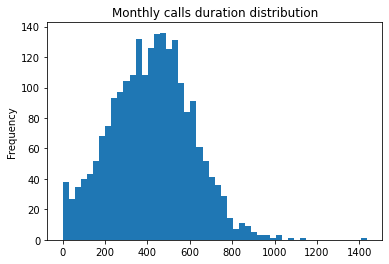

In [371]:
df_smart['calls_duration'].plot(kind='hist', bins=50, title='Monthly calls duration distribution')

<AxesSubplot:>

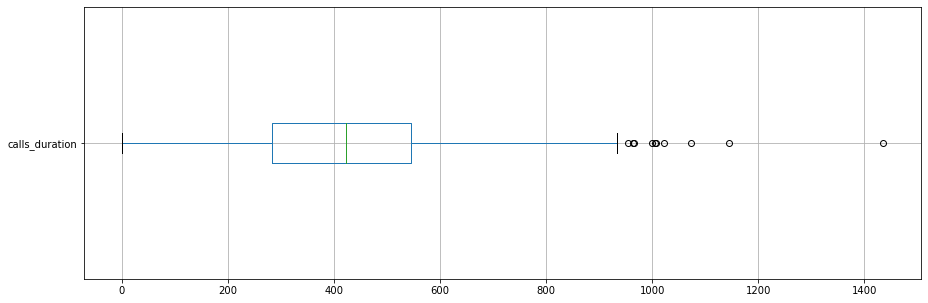

In [372]:
df_smart.boxplot('calls_duration', vert=False, figsize=(15,5))

Calls look to be skewed towards the right side with strong outliers, however the mean and median are not too far from each other. 

In [373]:
df_smart[df_smart['calls_duration'] >= 500]['calls_duration'].count() / len(df_smart)

0.3396141767608793

Around 34% of cases lie above the "free" limits of the tariff. 

<AxesSubplot:title={'center':'Monthly messages sent distribution'}, ylabel='Frequency'>

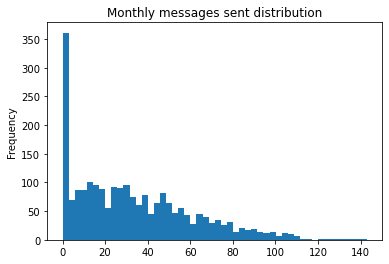

In [374]:
df_smart['messages'].plot(kind='hist', bins=50, title='Monthly messages sent distribution')

In [375]:
df_smart[df_smart['messages'] >= 50]['messages'].count() / len(df_smart)

0.26065500224315835

In many cases users don't write messages at all which is not surprising. However, on the other hand, there are 26% of cases when users brake the "free" limits of the tariff and send more than 50 messages.

<AxesSubplot:title={'center':'Monthly GBs used distribution'}, ylabel='Frequency'>

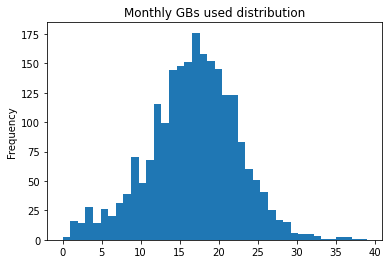

In [376]:
df_smart['gb_used'].plot(kind='hist', bins=40, title='Monthly GBs used distribution')

In [377]:
df_smart[df_smart['gb_used'] >= 15]['gb_used'].count() / len(df_smart)

0.670704351727232

- The distribution of monthly traffic used looks more normal than others  
- Its mean and median are shifted more to right from 15GB tariff "free" limit  
- In 67% of cases users break the limit

<AxesSubplot:title={'center':'Monthly revenue distribution'}, ylabel='Frequency'>

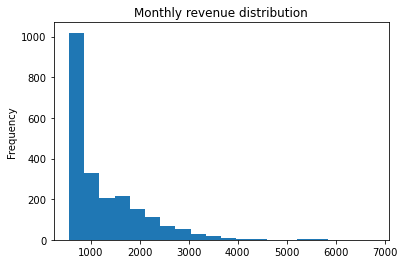

In [378]:
df_smart['revenue'].plot(kind='hist', bins=20, title='Monthly revenue distribution')

<AxesSubplot:>

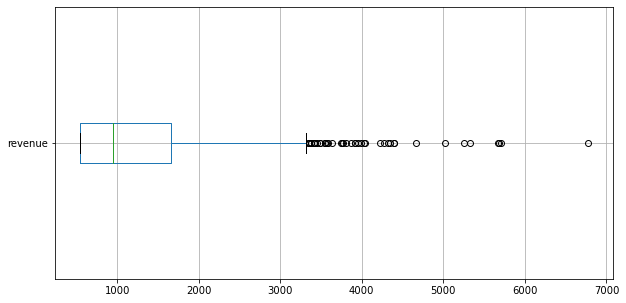

In [379]:
df_smart.boxplot('revenue', vert=False, figsize=(10,5))

<AxesSubplot:xlabel='gb_used', ylabel='revenue'>

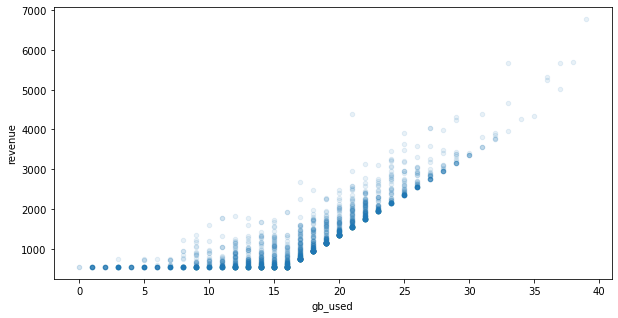

In [380]:
df_smart.plot(x='gb_used', y='revenue', kind='scatter', alpha=0.1, figsize=(10,5))

In [381]:
len(df_smart.query('revenue <= 550')) / len(df_smart)

0.2759084791386272

In [382]:
len(df_smart.query('revenue >= 1950')) / len(df_smart)

0.1816958277254374

- In only around 28% of cases users stay within the "free" limits of the tariff in all aspects and pay just the tariff price
- The distribution of the revenue is very skewed to the right with the average being way higher than median due to big outliers
- There is clear and strong dependence between the total monthly internet traffic used and revenues
- In around of 18% of the cases users could easily switch to the "ultra" tariff and pay less

In [383]:
# we check statistics for Smart tariff

df_ultra = df_a[df_a['tariff'] == 'ultra']
df_ultra.describe()

,user_id,month,calls_duration,messages,gb_used,revenue
count,985.00,985.00,985.00,985.00,985.00,985.00
mean,1263.09,8.25,526.62,49.36,19.97,2066.80
std,140.69,2.87,317.61,47.80,10.10,371.93
min,1000.00,1.00,0.00,0.00,0.00,1950.00
25%,1143.00,6.00,284.00,6.00,12.00,1950.00
50%,1277.00,9.00,518.00,38.00,20.00,1950.00
75%,1381.00,11.00,752.00,79.00,27.00,1950.00
max,1495.00,12.00,1673.00,224.00,50.00,4800.00


**The "Ultra" tariff**:
- around 30% of paying users
- monthly calls duration is 527 minutes on average and 518 minutes in median; both are way below the limits
- max monthly calls duration is 1673 minutes which is almost 50% than a tariff limit
- users send 49 messages on average and 38 ones in 50% of cases; the max monthly number is way below the limit
- both mean and median for amount of monthly traffic used on this tariff is around 20 GB which is 10GB less than the limit
- most of the cases for the gb_used are below the limits, however there are some cases that are above the limits
- users pay 2067 rubles on average monthly, while in 50% of cases they pay 1950 under this tariff
- all the additional revenue generated above the tariff price comes only from the fees from the traffic being used above the limits

<AxesSubplot:title={'center':'Monthly calls duration distribution'}, ylabel='Frequency'>

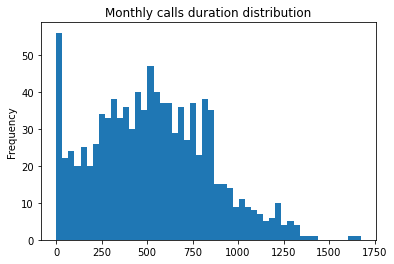

In [384]:
df_ultra['calls_duration'].plot(kind='hist', bins=50, title='Monthly calls duration distribution')

In [385]:
len(df_ultra.query('calls_duration == 0')) / len(df_ultra)

0.03857868020304569

- Calls look to be skewed towards the right side with some outliers, however the mean and median are not too far from each other
- Around 4% of cases have zero monthly calls

<AxesSubplot:title={'center':'Monthly messages sent distribution'}, ylabel='Frequency'>

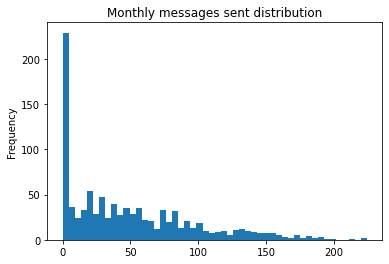

In [386]:
df_ultra['messages'].plot(kind='hist', bins=50, title='Monthly messages sent distribution')

In [387]:
len(df_ultra.query('messages == 0')) / len(df_ultra)

0.19289340101522842

In many cases (around 20%) users don't write messages at all which is not surprising.

<AxesSubplot:title={'center':'Monthly GBs used distribution'}, ylabel='Frequency'>

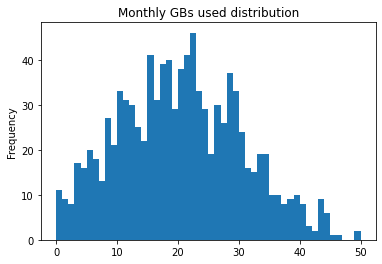

In [388]:
df_ultra['gb_used'].plot(kind='hist', bins=50, title='Monthly GBs used distribution')

In [389]:
len(df_ultra.query('gb_used > 30')) / len(df_ultra)

0.150253807106599

- The distribution of monthly traffic used looks more normal than others  
- Its mean and median are shifted way to left from 30GB tariff "free" limit; around 85% of cases are within the limits  
- In 15% of cases users break the limit

<AxesSubplot:title={'center':'Monthly revenue distribution'}, ylabel='Frequency'>

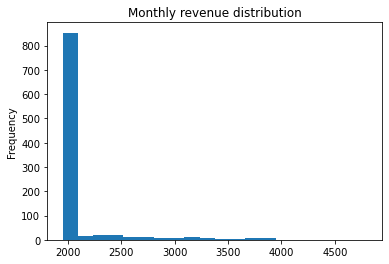

In [390]:
df_ultra['revenue'].plot(kind='hist', bins=20, title='Monthly revenue distribution')

<AxesSubplot:xlabel='gb_used', ylabel='revenue'>

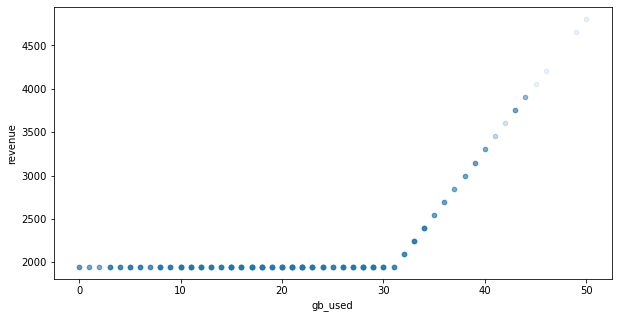

In [391]:
df_ultra.plot(x='gb_used', y='revenue', kind='scatter', alpha=0.1, figsize=(10,5))

In [392]:
len(df_ultra.query('calls_duration<=500 and messages<=50 and gb_used<=15')) / len(df_ultra)

0.1401015228426396

- As already stated above, all the cases where users pay more than just the tariff price are due to the break of traffic limits
- So in 85% of cases, users pay just the tariff price and in 15% - more
- In around 14% of cases users definetely could go down to "Smart" tariff and pay almost 4 times less
- For all the other cases, the deeper analysis is needed

We compare two tariffs and see which one generates more revenue.

In [393]:
df_a.groupby('tariff')['revenue'].agg(['sum', 'count' ,'mean'])

,sum,count,mean
tariff,,,
smart,2730751,2229,1225.10
ultra,2035800,985,2066.80


"Ultra" tariff is more preferrable for the telecom company due to:  
   - Higher monthly mean revenue on the user
   - The fact that user under this tariff do not fully use "free" limits

## Hypothesis checks

**1) Average revenues under "Smart" and "Ultra" tariffs:**
- H0: Average revenue of "Smart" = average revenue of "Ultra"
- H1: Average revenue of "Smart" != average revenue of "Ultra"
- Confidence level of 1% and 5%

The samples are independent, so we take the t-test for independent variables.

In [394]:
# we get the samples with the revenues of both tariffs

df_smart_h = df_smart['revenue'] 
df_ultra_h = df_ultra['revenue']

In [395]:
# we do the t-test for ind

results = st.ttest_ind(df_smart_h, df_ultra_h, equal_var = False)
print(f'p-value: {results.pvalue:.5f}')

p-value: 0.00000


P-value for this t-test is tending to zero, so independently on any confidence level choosen being 1%, 5%, or any other % - the H0 is **rejected**.

**2) Average revenues in Moscow and other cities (under both tariffs):**
- H0: Average revenue in Moscow = average revenue in other cities
- H1: Average revenue in Moscow != average revenue in other cities
- Confidence level of 1% and 5%

The samples are independent, so we take the t-test for independent variables.

In [396]:
# we get the samples with the revenues of both tariffs

df_moscow = df_a.query('city == "Москва"')['revenue']
df_other_cities = df_a.query('city != "Москва"')['revenue']

In [397]:
# we do the t-test for ind

results = st.ttest_ind(df_moscow, df_other_cities, equal_var = False)
print(f'p-value: {results.pvalue:.5f}')

p-value: 0.44297


P-value for this t-test is around 44%, so independently on any confidence level choosen being 1% and 5% - the H0 **can not be rejected**.

## Results

- We had a sample of monthly actions of 500 users in 2018 year (so in total could get 500x12=6000 data points)
- In only 54% of cases the revenue was generated due to the fact that some users joined the tariff when the year already started and some quited the tariff before the year end
- Out of the cases above the split between "Smart" and "Ultra" tariffs were around 70% and 30%, respectively
- Under "Smart" tariff users pay 1225 rubles on average monthly, while in 50% of cases they pay 950; both numbers are higher then the monthly tariff price due to the fact that users break the 'free' limits for everything quite a lot: calls, messages, and internet
- Under "Ultra" tariff users pay 2067 rubles on average monthly, while in 50% of cases they pay 1950 rubles; all the additional revenue generated above the tariff price comes only from the fees from the traffic being used above the limits
- "Ultra" tariff seems more preferrable for the telecom company due to the higher monthly mean revenue
- Comparing average revenues for "Smart" and "Ultra" tariffs samples, we can not conclude that they are equal (i.e. H0 is rejected)
- Comparing average revenues for both tariffs together in Moscow and other cities, we can not conclude that they are not equal (i.e. H0 is not rejected) as the t-test shows the statistically significant p-value
